In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
%matplotlib inline
plt.style.use('seaborn')


In [3]:
!ls data

Coinbase_BTCUSD_1h.csv Coinbase_LTCUSD_1h.csv TRADES
Coinbase_ETHUSD_1h.csv NORM


In [4]:
DATA = Path('./data')
TRADES_PATH = DATA / 'TRADES'

In [5]:
frame = pd.read_csv(DATA / 'Coinbase_BTCUSD_1h.csv')

In [6]:
frame.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,2018-07-30 10-PM,BTCUSD,8112.52,8199.99,8112.51,8163.01,545.56,4454633.33
1,2018-07-30 09-PM,BTCUSD,8146.15,8150.00,8110.00,8112.52,210.88,1712630.83
2,2018-07-30 08-PM,BTCUSD,8105.28,8178.00,8060.53,8146.15,726.42,5900438.14
3,2018-07-30 07-PM,BTCUSD,7951.29,8130.00,7951.29,8105.28,911.42,7337428.44
4,2018-07-30 06-PM,BTCUSD,7902.44,7963.33,7850.00,7951.29,1227.87,9713745.30


In [7]:
frame.describe()

,Open,High,Low,Close,Volume From,Volume To
count,9463.000000,9463.000000,9463.000000,9463.000000,9463.000000,9.463000e+03
mean,7711.556607,7767.323480,7649.869881,7712.164054,676.658990,5.781380e+06
std,3598.477755,3639.001181,3551.375031,3598.079447,734.906626,8.446485e+06
min,1785.010000,1858.270000,1758.200000,1785.010000,0.000000,0.000000e+00
25%,4734.005000,4745.825000,4704.205000,4736.440000,264.810000,1.450961e+06
50%,7425.000000,7458.000000,7387.510000,7425.000000,460.480000,2.996567e+06
75%,9297.305000,9339.000000,9246.400000,9297.305000,816.825000,6.730248e+06
max,19847.110000,19891.990000,19725.980000,19847.110000,10464.320000,1.438437e+08


In [8]:
prices = frame['Close'].values

[Text(0,0.5,'Closing price'),
 Text(0.5,0,'Hours'),
 Text(0.5,1,'Closing price BTC/USD vs Hours')]

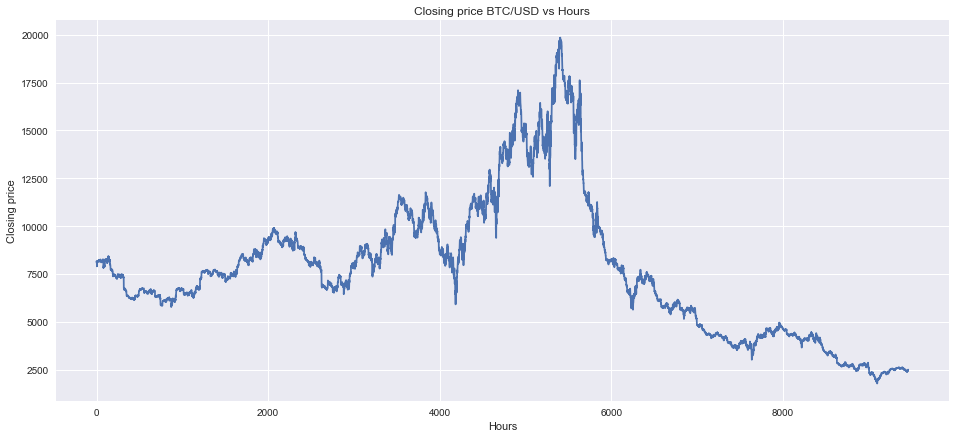

In [9]:
fig, axes = plt.subplots(figsize=(16,7))
axes.plot(prices)
axes.set(xlabel='Hours',ylabel='Closing price',title='Closing price BTC/USD vs Hours')

## Analysis
We would place short term trades on a day to day scale, so lets look at a 5 days

[Text(0,0.5,'Closing price'), Text(0.5,0,'Hours'), Text(0.5,1,'5 Days')]

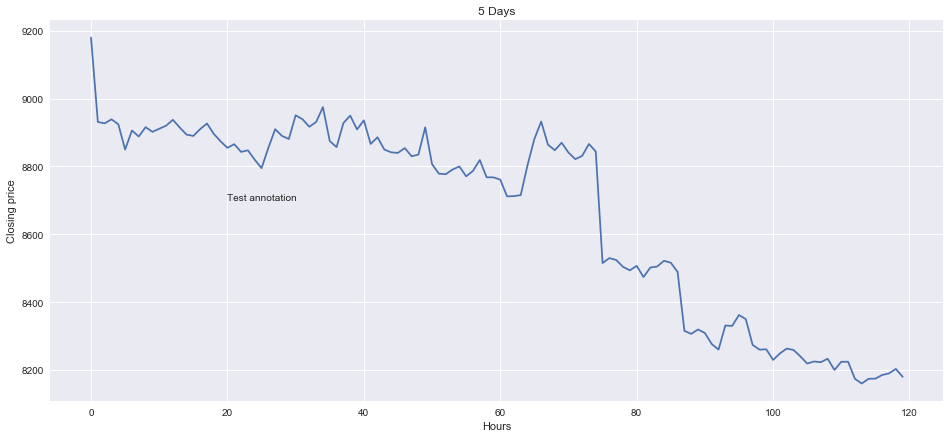

In [10]:
interval = 24 * 5
start = 2345

interval_prices = prices[start:start+interval]

fig, axes = plt.subplots(figsize=(16,7))
axes.plot(interval_prices)
annot = axes.annotate('Test annotation', [20, 8700])
axes.set(xlabel='Hours', ylabel='Closing price', title='5 Days')

The longer the time period we try to predict the less confident we will be in that prediction. So lets say the maximum lookout is 2 days. We could do

# Trading algorithm 
The algorithm that will produce true labels for trades in a given window

In [41]:
# Useful constants and definitions
operations = {
    'NOOP': 0,
    'SELL': 1,
    'BUY': 2, 
}
profit_threshold = 0.05
OP_WINDOW_LEN = 2*24
ANALYSIS_WINDOW_LEN = 2*24
FRAME_LEN = OP_WINDOW_LEN + ANALYSIS_WINDOW_LEN

In [42]:
# for visualizing the trades our algorithm decided to make
def plot_trades(prices, trades, analysis_window_len):
    fig, axes = plt.subplots(figsize=(16, 7))
    axes.plot(prices)
    axes.axvline(analysis_window_len, ls='--', color='r')
    axes.set(xlabel='Hours', ylabel='Closing price', title='One Frame (two windows)')
    for idx, operation in enumerate(trades):
        if operation != operations['NOOP']:
            label = itoo[operation]
            x, y = idx, prices[idx]# offset
            bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[label], ec="b", lw=2)
            annot = axes.annotate(label, xy=(x, y), xytext=(x,y), bbox=bbox_props)

### Multi-Trade Algorithm 
can support multiple trades at any one time

In [43]:
def multi_trade(prices, trades, idx=ANALYSIS_WINDOW_LEN, lookout=OP_WINDOW_LEN):
    """
    frame is divided into two windows:
        one from which our predictions are made
        other in which we place our operations
    knowing lookout distance we can divide into frames after
    """
    if idx + lookout >= len(prices): return
    operations_window = enumerate(prices[idx: idx+lookout].copy())
    operations_window = sorted(operations_window, key=lambda x: x[1])
    for i in range(len(operations_window) // 2):
        early, late = find_anchor(operations_window, i) # find which one happened earlier so we can calculate pchange
        pchange = (operations_window[early][1] - operations_window[late][1]) / operations_window[early][1]

        if -pchange >= profit_threshold:
            start_offset = operations_window[early][0]
            end_offset = operations_window[late][0]
            trades[idx+start_offset] = operations['BUY']
            trades[idx+end_offset] = operations['SELL']
            #return
            
    multi_trade(prices, trades, idx=idx+lookout) # in case no trades can be made 
    
def find_anchor(sarray, idx): # sarray = sorted array
    contra= -(idx+1) # if 0 then -1
    if sarray[idx][0] > sarray[contra][0]:
        return contra , idx
    else:
        return idx, contra

In [44]:
prices = frame['Close'].values
multi_trades = np.ones(len(prices),dtype=np.int) * operations['NOOP']

In [45]:
%time multi_trade(prices, multi_trades)

CPU times: user 12.5 ms, sys: 1.05 ms, total: 13.6 ms
Wall time: 12.7 ms


In [46]:
op_count = np.bincount(multi_trades)
assert op_count[1] == op_count[2], "not all trades match"
print(f"[{op_count[1]}] possible trades can be made")

[705] possible trades can be made


### Visualization of the Multi-Trade algorithm 

number of frames available: [196]
frame number: [39]; starting index: [1872]
do operations match up: [True]


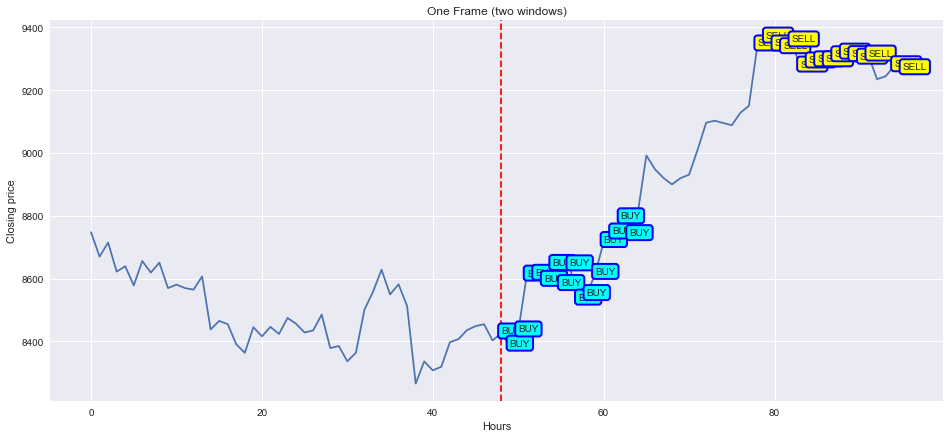

In [50]:
colors = {
    'SELL': 'yellow',
    'SHORT': 'green',
    'BUY': 'cyan', 
}

nframes = (len(prices) - ANALYSIS_WINDOW_LEN) // OP_WINDOW_LEN # the first window

print(f"number of frames available: [{nframes}]")
chosen_frame = np.random.randint(0, nframes)
start = chosen_frame * OP_WINDOW_LEN

print(f"frame number: [{chosen_frame}]; starting index: [{start}]")
itoo = {v:k for k,v in operations.items()} # reverse mapping
interval_prices = prices[start: start+FRAME_LEN].copy()
interval_trades = multi_trades[start: start+FRAME_LEN].copy()
interval_trades[0: ANALYSIS_WINDOW_LEN] = np.ones(ANALYSIS_WINDOW_LEN) * operations['NOOP'] 

# CHECK
op_count = np.bincount(interval_trades)
if len(op_count) > 1: print(f"do operations match up: [{op_count[1] == op_count[2]}]")
plot_trades(interval_prices, interval_trades, ANALYSIS_WINDOW_LEN)


Will be problems with identifying which action a trade refers to; Also when splitting into batches will be pretty difficult to determine the trade period

In [ ]:
np.save(TRADES_PATH / 'trades_btc_multi_v2.npy', multi_trades)

## Lets repeat the same thing for ETH and LTC 

In [ ]:
eth = pd.read_csv(DATA / 'Coinbase_ETHUSD_1h.csv')
ltc = pd.read_csv(DATA / 'Coinbase_LTCUSD_1h.csv')

In [ ]:
eth_prices = eth['Close'].values
eth_multi_trades = np.ones(len(eth_prices)) * operations['NOOP']
multi_trade(eth_prices, eth_multi_trades)
np.save(TRADES_PATH / 'trades_eth_multi_v2.npy', eth_multi_trades)

In [ ]:
ltc_prices = ltc['Close'].values
ltc_multi_trades = np.ones(len(ltc_prices)) * operations['NOOP']
multi_trade(ltc_prices, ltc_multi_trades)
np.save(TRADES_PATH / 'trades_ltc_multi_v2.npy', ltc_multi_trades)